<a href="https://colab.research.google.com/github/CoiferousYogi/BK-Birla_L-T_ML_Assignments/blob/main/_%26T_Assignment4_MovieRecommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
# Update the dataset handle to the correct path
# Make sure the path is 'tmdb/tmdb-movie-metadata' and not 'organizations/tmdb/tmdb-movie-metadata'
organizations_tmdb_tmdb_movie_metadata_path = kagglehub.dataset_download('tmdb/tmdb-movie-metadata')

print('Data source import complete.')

Data source import complete.


In [94]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv
/kaggle/input/tmdb-movie-metadata/tmdb_5000_credits.csv


In [95]:
import numpy as np
import pandas as pd
import ast
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [96]:
#Reading the datasets
movies = pd.read_csv('/kaggle/input/tmdb-movie-metadata/tmdb_5000_credits.csv')
credits = pd.read_csv('/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv')


## Basic Questions about the data

### 1. movies dataset

In [97]:
# Q1. What is the size of the dataset?
movies.shape

(4803, 4)

**The movies dataset contains 4803 rows and 4 columns**

In [98]:
# Q2. What does the dataset look like?
movies.sample(3)

,movie_id,title,cast,crew
1065,10478,Tin Cup,"[{""cast_id"": 10, ""character"": ""Roy 'Tin Cup' M...","[{""credit_id"": ""564856d2c3a3682614006cf5"", ""de..."
2740,10985,The New Guy,"[{""cast_id"": 11, ""character"": ""Dizzy Harrison ...","[{""credit_id"": ""5814840cc3a3687aa0030ad0"", ""de..."
623,38778,Dinner for Schmucks,"[{""cast_id"": 4, ""character"": ""Barry"", ""credit_...","[{""credit_id"": ""52fe46df9251416c910628d5"", ""de..."


In [99]:
# Q3. What is the datatype of each feature?
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


In [100]:
# Q4. Are there any missing values in the dataset?
movies.isnull().sum()

,0
movie_id,0
title,0
cast,0
crew,0


**No missing values in the movies dataset**

In [101]:
# Q5. Are there any duplicate values in the dataset?
movies.duplicated().sum()

np.int64(0)

**No duplicate values in the dataset**

In [102]:
# Q6. How does the data look like mathematically?
movies.describe()

,movie_id
count,4803.000000
mean,57165.484281
std,88694.614033
min,5.000000
25%,9014.500000
50%,14629.000000
75%,58610.500000
max,459488.000000


### 2. Credits dataset

In [103]:
# What are the dimensions of the dataset?
credits.shape

(4803, 20)

**The credits dataset has 4803 rows with 20 features(columns)**

In [104]:
# Q2. What does the dataset look like?
credits.sample(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
3600,5000000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 53, ""nam...",NaN,11357,"[{""id"": 798, ""name"": ""sheriff""}, {""id"": 1435, ...",en,Halloween 4: The Return of Michael Myers,"The legend of that creepy masked-man, Michael ...",9.302349,"[{""name"": ""Dimension Films"", ""id"": 7405}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1988-10-21,17768757,88.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Horror has returned to Haddonfield.,Halloween 4: The Return of Michael Myers,5.9,209
1790,26000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",NaN,134,"[{""id"": 530, ""name"": ""prophecy""}, {""id"": 531, ...",en,"O Brother, Where Art Thou?","In the deep south during the 1930s, three esca...",39.742009,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""FR"", ""name"": ""France""}, {""iso...",2000-08-30,71868327,106.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,They have a plan...but not a clue.,"O Brother, Where Art Thou?",7.3,1112
3014,10000000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 878, ""na...",NaN,11336,"[{""id"": 732, ""name"": ""coma""}, {""id"": 798, ""nam...",en,The Dead Zone,Johnny Smith is a schoolteacher with his whole...,16.785120,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1983-10-21,20766616,103.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,"In his mind, he has the power to see the futur...",The Dead Zone,6.9,311


**There are a few missing values entered as NaN. Need a way to handle those.**

In [105]:
# Q3. What is the datatype of each feature?
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

**There seems to be no discrepency between the datatypes of features and the feature content.**

In [106]:
# Q4. Are there any missing values in the dataset?
credits.isnull().sum()

,0
budget,0
genres,0
homepage,3091
id,0
keywords,0
original_language,0
original_title,0
overview,3
popularity,0
production_companies,0


**homepage and tagline features have 3091 and 844 missing values respectively. But these are not important features for the recommendation system.**

In [107]:
# Q5. Are there any duplicate values in the dataset?
credits.duplicated().sum()

np.int64(0)

**No duplicate values found.**

### Data Collection

In [108]:
movies.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [109]:
# Credits dataset
credits.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


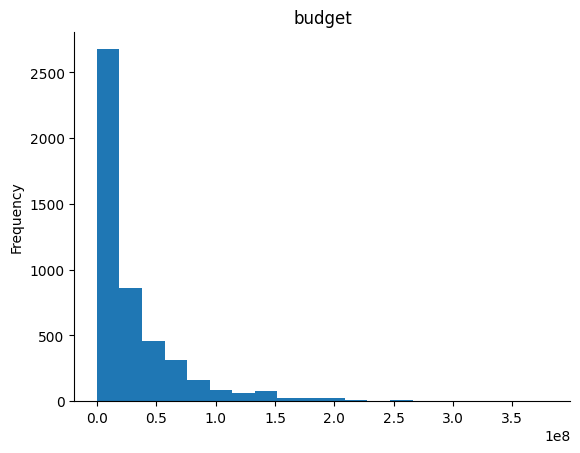

In [110]:
# @title budget

from matplotlib import pyplot as plt
credits['budget'].plot(kind='hist', bins=20, title='budget')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [111]:
# Merging movies and credits datasets. Merging credits into movies
# On the basis of title
movies.merge(credits, on='title').shape

(4809, 23)

In [112]:
# Let the merged dataset be saved as df
df = movies.merge(credits, on='title')

In [113]:
df.shape

(4809, 23)

In [114]:
df.sample()

,movie_id,title,cast,crew,budget,genres,homepage,id,keywords,original_language,...,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
2319,157,Star Trek III: The Search for Spock,"[{""cast_id"": 5, ""character"": ""Admiral James T....","[{""credit_id"": ""52fe4220c3a36847f8005eb3"", ""de...",18000000,"[{""id"": 878, ""name"": ""Science Fiction""}, {""id""...",NaN,157,[],en,...,"[{""name"": ""Paramount Pictures"", ""id"": 4}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1984-05-31,87000000,105.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,A dying planet. A fight for life.,6.4,434


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_id              4809 non-null   int64  
 1   title                 4809 non-null   object 
 2   cast                  4809 non-null   object 
 3   crew                  4809 non-null   object 
 4   budget                4809 non-null   int64  
 5   genres                4809 non-null   object 
 6   homepage              1713 non-null   object 
 7   id                    4809 non-null   int64  
 8   keywords              4809 non-null   object 
 9   original_language     4809 non-null   object 
 10  original_title        4809 non-null   object 
 11  overview              4806 non-null   object 
 12  popularity            4809 non-null   float64
 13  production_companies  4809 non-null   object 
 14  production_countries  4809 non-null   object 
 15  release_date         

#### Extracting the useful features from the dataframe.

**Useful Features:**
<li>movie_id</li>
<li>title</li>
<li>cast</li>
<li>crew</li>
<li>genres</li>
<li>keywords</li>
<li>vote_average</li>
<li>overview</li>

In [116]:
movies_df = df[['movie_id', 'title','cast','crew','genres','keywords','vote_average','overview']]

In [117]:
movies_df.sample(3)

,movie_id,title,cast,crew,genres,keywords,vote_average,overview
41,44912,Green Lantern,"[{""cast_id"": 6, ""character"": ""Hal Jordan / Gre...","[{""credit_id"": ""52fe46a3c3a36847f8109f09"", ""de...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 4375...",5.1,"For centuries, a small but powerful force of w..."
4001,43306,A Guy Named Joe,"[{""cast_id"": 1, ""character"": ""Pete Sandidge"", ...","[{""credit_id"": ""56cc01fe92514124610017df"", ""de...","[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...","[{""id"": 3203, ""name"": ""pilot""}, {""id"": 3800, ""...",6.0,"Pete Sandidge (Tracy), a daredevil bomber pilo..."
633,72976,Lincoln,"[{""cast_id"": 4, ""character"": ""Abraham Lincoln""...","[{""credit_id"": ""52fe4886c3a368484e0fd461"", ""de...","[{""id"": 36, ""name"": ""History""}, {""id"": 18, ""na...","[{""id"": 840, ""name"": ""usa president""}, {""id"": ...",6.7,A revealing drama that focuses on the 16th Pre...


In [118]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movie_id      4809 non-null   int64  
 1   title         4809 non-null   object 
 2   cast          4809 non-null   object 
 3   crew          4809 non-null   object 
 4   genres        4809 non-null   object 
 5   keywords      4809 non-null   object 
 6   vote_average  4809 non-null   float64
 7   overview      4806 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 300.7+ KB


#### Checking for duplicate values

In [119]:
movies_df.duplicated().sum()

np.int64(0)

**No duplicate values found.**

#### Checking for missing values

In [120]:
# Checking for missing values
movies_df.isnull().sum()

,0
movie_id,0
title,0
cast,0
crew,0
genres,0
keywords,0
vote_average,0
overview,3


**There are 3 entries which have missing values**

In [121]:
# finding the rows with missing values for overviews
movies_df.loc[movies_df.isnull().any(axis=1)]

,movie_id,title,cast,crew,genres,keywords,vote_average,overview
2658,370980,Chiamatemi Francesco - Il Papa della gente,"[{""cast_id"": 5, ""character"": ""Jorge Mario Berg...","[{""credit_id"": ""5660019ac3a36875f100252b"", ""de...","[{""id"": 18, ""name"": ""Drama""}]","[{""id"": 717, ""name"": ""pope""}, {""id"": 5565, ""na...",7.3,NaN
4145,459488,"To Be Frank, Sinatra at 100","[{""cast_id"": 0, ""character"": ""Narrator"", ""cred...","[{""credit_id"": ""592b25e4c3a368783e065a2f"", ""de...","[{""id"": 99, ""name"": ""Documentary""}]","[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...",0.0,NaN
4437,292539,Food Chains,[],"[{""credit_id"": ""5470c3b1c3a368085e000abd"", ""de...","[{""id"": 99, ""name"": ""Documentary""}]",[],7.4,NaN


**Dropping the missing values**

In [122]:
movies_df.dropna(inplace=True)

<ipython-input-122-7b8d164d18f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df.dropna(inplace=True)


In [123]:
movies_df.isnull().sum()

,0
movie_id,0
title,0
cast,0
crew,0
genres,0
keywords,0
vote_average,0
overview,0


In [124]:
movies_df.shape

(4806, 8)

## Feature Engineering

**Converting the features into proper format**

In [125]:
movies_df.iloc[0].genres

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

**We need genres of a movie as an array without an id**

In [126]:
type(movies_df)

pandas.core.frame.DataFrame

In [127]:
def custom_convert(obj):
    L=[]
    for i in ast.literal_eval(obj):
        L.append(i['name'])
    return L

#### Converting the genres column

In [128]:
movies_df['genres'] = movies_df['genres'].apply(custom_convert)

<ipython-input-128-790b810d1c83>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['genres'] = movies_df['genres'].apply(custom_convert)


In [129]:
movies_df.head(3)

,movie_id,title,cast,crew,genres,keywords,vote_average,overview
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...","[Action, Adventure, Fantasy, Science Fiction]","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",7.2,"In the 22nd century, a paraplegic Marine is di..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...","[Adventure, Fantasy, Action]","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",6.9,"Captain Barbossa, long believed to be dead, ha..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...","[Action, Adventure, Crime]","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",6.3,A cryptic message from Bond’s past sends him o...


**Applying the custom converter to the keywords column**

In [130]:
movies_df['keywords'] = movies_df['keywords'].apply(custom_convert)

<ipython-input-130-2b812bd0fbcc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['keywords'] = movies_df['keywords'].apply(custom_convert)


In [131]:
movies_df.head(3)

,movie_id,title,cast,crew,genres,keywords,vote_average,overview
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...",7.2,"In the 22nd century, a paraplegic Marine is di..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...",6.9,"Captain Barbossa, long believed to be dead, ha..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...","[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...",6.3,A cryptic message from Bond’s past sends him o...


In [132]:
movies_df.iloc[0].cast

'[{"cast_id": 242, "character": "Jake Sully", "credit_id": "5602a8a7c3a3685532001c9a", "gender": 2, "id": 65731, "name": "Sam Worthington", "order": 0}, {"cast_id": 3, "character": "Neytiri", "credit_id": "52fe48009251416c750ac9cb", "gender": 1, "id": 8691, "name": "Zoe Saldana", "order": 1}, {"cast_id": 25, "character": "Dr. Grace Augustine", "credit_id": "52fe48009251416c750aca39", "gender": 1, "id": 10205, "name": "Sigourney Weaver", "order": 2}, {"cast_id": 4, "character": "Col. Quaritch", "credit_id": "52fe48009251416c750ac9cf", "gender": 2, "id": 32747, "name": "Stephen Lang", "order": 3}, {"cast_id": 5, "character": "Trudy Chacon", "credit_id": "52fe48009251416c750ac9d3", "gender": 1, "id": 17647, "name": "Michelle Rodriguez", "order": 4}, {"cast_id": 8, "character": "Selfridge", "credit_id": "52fe48009251416c750ac9e1", "gender": 2, "id": 1771, "name": "Giovanni Ribisi", "order": 5}, {"cast_id": 7, "character": "Norm Spellman", "credit_id": "52fe48009251416c750ac9dd", "gender": 

In [133]:
movies_df.iloc[0].crew

'[{"credit_id": "52fe48009251416c750aca23", "department": "Editing", "gender": 0, "id": 1721, "job": "Editor", "name": "Stephen E. Rivkin"}, {"credit_id": "539c47ecc3a36810e3001f87", "department": "Art", "gender": 2, "id": 496, "job": "Production Design", "name": "Rick Carter"}, {"credit_id": "54491c89c3a3680fb4001cf7", "department": "Sound", "gender": 0, "id": 900, "job": "Sound Designer", "name": "Christopher Boyes"}, {"credit_id": "54491cb70e0a267480001bd0", "department": "Sound", "gender": 0, "id": 900, "job": "Supervising Sound Editor", "name": "Christopher Boyes"}, {"credit_id": "539c4a4cc3a36810c9002101", "department": "Production", "gender": 1, "id": 1262, "job": "Casting", "name": "Mali Finn"}, {"credit_id": "5544ee3b925141499f0008fc", "department": "Sound", "gender": 2, "id": 1729, "job": "Original Music Composer", "name": "James Horner"}, {"credit_id": "52fe48009251416c750ac9c3", "department": "Directing", "gender": 2, "id": 2710, "job": "Director", "name": "James Cameron"},

**Need to get rid of the id and order and just keep the names.**

In [134]:
def custom_convert2(obj):
    L = []
    counter = 0
    for i in ast.literal_eval(obj):
        if counter != 10:
            L.append(i['name'])
        else:
            break
    return L

In [135]:
movies_df['cast'] = movies_df['cast'].apply(custom_convert2)

<ipython-input-135-c5fc2cb12c8f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['cast'] = movies_df['cast'].apply(custom_convert2)


In [136]:
movies_df.head(3)

,movie_id,title,cast,crew,genres,keywords,vote_average,overview
0,19995,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...",7.2,"In the 22nd century, a paraplegic Marine is di..."
1,285,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...",6.9,"Captain Barbossa, long believed to be dead, ha..."
2,206647,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...","[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...",6.3,A cryptic message from Bond’s past sends him o...


In [137]:
# convert function for cast
def fetch_crew(obj):
    L = []
    for i in ast.literal_eval(obj):
        if i['job'] == 'Director' or i['job'] == "Writer" or i['job'] == 'Producer':
            L.append(i['name'])
    return L

In [138]:
movies_df['crew'] = movies_df['crew'].apply(fetch_crew)

<ipython-input-138-1f419039986e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['crew'] = movies_df['crew'].apply(fetch_crew)


In [139]:
movies_df.head(3)

,movie_id,title,cast,crew,genres,keywords,vote_average,overview
0,19995,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[James Cameron, James Cameron, James Cameron, ...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...",7.2,"In the 22nd century, a paraplegic Marine is di..."
1,285,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Gore Verbinski, Jerry Bruckheimer, Eric McLeo...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...",6.9,"Captain Barbossa, long believed to be dead, ha..."
2,206647,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[Sam Mendes, Barbara Broccoli, Michael G. Wilson]","[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...",6.3,A cryptic message from Bond’s past sends him o...


In [140]:
movies_df['overview'] = movies_df['overview'].apply(lambda x:str(x).split())

<ipython-input-140-ad6371d5ddff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['overview'] = movies_df['overview'].apply(lambda x:str(x).split())


In [141]:
movies_df.dtypes

,0
movie_id,int64
title,object
cast,object
crew,object
genres,object
keywords,object
vote_average,float64
overview,object


In [142]:
movies_df['genres'] = movies_df['genres'].apply(lambda x:[i.replace(' ','') for i in x])

<ipython-input-142-e78d485c4e7b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['genres'] = movies_df['genres'].apply(lambda x:[i.replace(' ','') for i in x])


In [143]:
movies_df['keywords']=movies_df['keywords'].apply(lambda x:[i.replace(' ','') for i in x])
movies['cast']=movies['cast'].apply(lambda x:[i.replace(' ','') for i in x])
movies['crew']=movies['crew'].apply(lambda x:[i.replace(' ','') for i in x])

<ipython-input-143-627891486ca0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['keywords']=movies_df['keywords'].apply(lambda x:[i.replace(' ','') for i in x])


In [144]:
movies_df.head(3)

,movie_id,title,cast,crew,genres,keywords,vote_average,overview
0,19995,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[James Cameron, James Cameron, James Cameron, ...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...",7.2,"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Gore Verbinski, Jerry Bruckheimer, Eric McLeo...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...",6.9,"[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[Sam Mendes, Barbara Broccoli, Michael G. Wilson]","[Action, Adventure, Crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...",6.3,"[A, cryptic, message, from, Bond’s, past, send..."


**Create a new column named tags to store all necessary info about each movies**

In [145]:
movies_df['tags'] = movies_df['overview']+movies_df['genres']+movies_df['keywords']+movies_df['cast']+movies_df['crew']

<ipython-input-145-853d625e9a72>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['tags'] = movies_df['overview']+movies_df['genres']+movies_df['keywords']+movies_df['cast']+movies_df['crew']


In [146]:
movies_df.head()

,movie_id,title,cast,crew,genres,keywords,vote_average,overview,tags
0,19995,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[James Cameron, James Cameron, James Cameron, ...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...",7.2,"[In, the, 22nd, century,, a, paraplegic, Marin...","[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Gore Verbinski, Jerry Bruckheimer, Eric McLeo...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...",6.9,"[Captain, Barbossa,, long, believed, to, be, d...","[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[Sam Mendes, Barbara Broccoli, Michael G. Wilson]","[Action, Adventure, Crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...",6.3,"[A, cryptic, message, from, Bond’s, past, send...","[A, cryptic, message, from, Bond’s, past, send..."
3,49026,The Dark Knight Rises,"[Christian Bale, Michael Caine, Gary Oldman, A...","[Charles Roven, Christopher Nolan, Christopher...","[Action, Crime, Drama, Thriller]","[dccomics, crimefighter, terrorist, secretiden...",7.6,"[Following, the, death, of, District, Attorney...","[Following, the, death, of, District, Attorney..."
4,49529,John Carter,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[Andrew Stanton, Colin Wilson, Jim Morris, Lin...","[Action, Adventure, ScienceFiction]","[basedonnovel, mars, medallion, spacetravel, p...",6.1,"[John, Carter, is, a, war-weary,, former, mili...","[John, Carter, is, a, war-weary,, former, mili..."


In [147]:
movies_df.tags[0]

['In',
 'the',
 '22nd',
 'century,',
 'a',
 'paraplegic',
 'Marine',
 'is',
 'dispatched',
 'to',
 'the',
 'moon',
 'Pandora',
 'on',
 'a',
 'unique',
 'mission,',
 'but',
 'becomes',
 'torn',
 'between',
 'following',
 'orders',
 'and',
 'protecting',
 'an',
 'alien',
 'civilization.',
 'Action',
 'Adventure',
 'Fantasy',
 'ScienceFiction',
 'cultureclash',
 'future',
 'spacewar',
 'spacecolony',
 'society',
 'spacetravel',
 'futuristic',
 'romance',
 'space',
 'alien',
 'tribe',
 'alienplanet',
 'cgi',
 'marine',
 'soldier',
 'battle',
 'loveaffair',
 'antiwar',
 'powerrelations',
 'mindandsoul',
 '3d',
 'Sam Worthington',
 'Zoe Saldana',
 'Sigourney Weaver',
 'Stephen Lang',
 'Michelle Rodriguez',
 'Giovanni Ribisi',
 'Joel David Moore',
 'CCH Pounder',
 'Wes Studi',
 'Laz Alonso',
 'Dileep Rao',
 'Matt Gerald',
 'Sean Anthony Moran',
 'Jason Whyte',
 'Scott Lawrence',
 'Kelly Kilgour',
 'James Patrick Pitt',
 'Sean Patrick Murphy',
 'Peter Dillon',
 'Kevin Dorman',
 'Kelson Henders

**Create a new dataframe with columns 'movie_id', 'vote_average', 'title', 'tags'**

In [148]:
new_df = movies_df[['movie_id', 'vote_average', 'title', 'tags']]

In [149]:
new_df.head()

,movie_id,vote_average,title,tags
0,19995,7.2,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,6.9,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,6.3,Spectre,"[A, cryptic, message, from, Bond’s, past, send..."
3,49026,7.6,The Dark Knight Rises,"[Following, the, death, of, District, Attorney..."
4,49529,6.1,John Carter,"[John, Carter, is, a, war-weary,, former, mili..."


In [150]:
#Convert tags to string from list
new_df['tags']=new_df['tags'].apply(lambda x:' '.join(x))

<ipython-input-150-ce1dd699a0be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags']=new_df['tags'].apply(lambda x:' '.join(x))


In [151]:
new_df.head()

,movie_id,vote_average,title,tags
0,19995,7.2,Avatar,"In the 22nd century, a paraplegic Marine is di..."
1,285,6.9,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha..."
2,206647,6.3,Spectre,A cryptic message from Bond’s past sends him o...
3,49026,7.6,The Dark Knight Rises,Following the death of District Attorney Harve...
4,49529,6.1,John Carter,"John Carter is a war-weary, former military ca..."


In [152]:
new_df['tags'][0]

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. Action Adventure Fantasy ScienceFiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d Sam Worthington Zoe Saldana Sigourney Weaver Stephen Lang Michelle Rodriguez Giovanni Ribisi Joel David Moore CCH Pounder Wes Studi Laz Alonso Dileep Rao Matt Gerald Sean Anthony Moran Jason Whyte Scott Lawrence Kelly Kilgour James Patrick Pitt Sean Patrick Murphy Peter Dillon Kevin Dorman Kelson Henderson David Van Horn Jacob Tomuri Michael Blain-Rozgay Jon Curry Luke Hawker Woody Schultz Peter Mensah Sonia Yee Jahnel Curfman Ilram Choi Kyla Warren Lisa Roumain Debra Wilson Chris Mala Taylor Kibby Jodie Landau Julie Lamm Cullen B. Madden Joseph Brady Madden Frankie Torres Austin Wilson Sara

In [153]:
#Convert the string to lowercase
new_df['tags']=new_df['tags'].apply(lambda x:x.lower())

<ipython-input-153-a249f593be4c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags']=new_df['tags'].apply(lambda x:x.lower())


In [154]:
new_df.head()


,movie_id,vote_average,title,tags
0,19995,7.2,Avatar,"in the 22nd century, a paraplegic marine is di..."
1,285,6.9,Pirates of the Caribbean: At World's End,"captain barbossa, long believed to be dead, ha..."
2,206647,6.3,Spectre,a cryptic message from bond’s past sends him o...
3,49026,7.6,The Dark Knight Rises,following the death of district attorney harve...
4,49529,6.1,John Carter,"john carter is a war-weary, former military ca..."


## Recommendation System

In [155]:
cv = CountVectorizer(max_features=5000, stop_words='english')

In [156]:
#Transform every word into a vector
vectors=cv.fit_transform(new_df['tags']).toarray()

In [157]:
vectors.shape

(4806, 5000)

In [158]:
vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [159]:
ps = PorterStemmer()

In [160]:
#Define a new function to extract stem of the words only from the string
def stem(text):
    y=[]

    for i in str(text).split():
        y.append(ps.stem(i))
    return ' '.join(y)

In [161]:
new_df['tags']=new_df['tags'].apply(stem)

<ipython-input-161-402dd7cb6b10>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags']=new_df['tags'].apply(stem)


In [162]:
new_df['tags'][0]

'in the 22nd century, a parapleg marin is dispatch to the moon pandora on a uniqu mission, but becom torn between follow order and protect an alien civilization. action adventur fantasi sciencefict cultureclash futur spacewar spacecoloni societi spacetravel futurist romanc space alien tribe alienplanet cgi marin soldier battl loveaffair antiwar powerrel mindandsoul 3d sam worthington zoe saldana sigourney weaver stephen lang michel rodriguez giovanni ribisi joel david moor cch pounder we studi laz alonso dileep rao matt gerald sean anthoni moran jason whyte scott lawrenc kelli kilgour jame patrick pitt sean patrick murphi peter dillon kevin dorman kelson henderson david van horn jacob tomuri michael blain-rozgay jon curri luke hawker woodi schultz peter mensah sonia yee jahnel curfman ilram choi kyla warren lisa roumain debra wilson chri mala taylor kibbi jodi landau juli lamm cullen b. madden joseph bradi madden franki torr austin wilson sara wilson tamica washington-mil luci briant n

In [163]:
#Calculate the cosine distance between each vectors
similarity=cosine_similarity(vectors)

### Content Based Recommender System

In [164]:
#Function for Content Based Recommendation
def recommend_content(movie):
    movie_index= new_df[new_df['title']==movie].index[0]
    distances=similarity[movie_index]
    movies_list= sorted(list(enumerate(distances)), reverse=True,key=lambda x:x[1])[0:5]
    title=[]
    rating=[]
    for i in movies_list:
        title.append(new_df.iloc[i[0]].title)
        rating.append(new_df.iloc[i[0]].vote_average)
    df = pd.DataFrame(list(zip(title, rating)),
               columns =['title', 'rating'])
    return df

In [165]:
#Pass a movie name through the function and get 5 movies recommended by content
recommended_movies=recommend_content('No Country for Old Men')
recommended_movies

,title,rating
0,No Country for Old Men,7.7
1,Inside Llewyn Davis,7.2
2,True Grit,7.2
3,The Ladykillers,6.0
4,A Serious Man,6.6


### Making an app using Gradio for content based Recommender system

In [180]:
# importing the libraries
import numpy as np
import pandas as pd
!pip install gradio
import gradio as gr

#Function for Content Based Recommendation
def recommend_content(movie):
    movie_index= new_df[new_df['title']==movie].index[0]
    distances=similarity[movie_index]
    movies_list= sorted(list(enumerate(distances)), reverse=True,key=lambda x:x[1])[0:5]
    title=[]
    rating=[]
    for i in movies_list:
        title.append(new_df.iloc[i[0]].title)
        rating.append(new_df.iloc[i[0]].vote_average)
    df = pd.DataFrame(list(zip(title, rating)),
               columns =['title', 'rating'])
    return df

app_interface = gr.Interface(fn=recommend_content,
                             inputs=gr.Textbox(lines=1, placeholder="Enter a movie name"),
                             title="Movie Recommendation System",
                             description="Enter a movie name and get 5 movies recommended by content",
                             outputs="dataframe")

app_interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://77e87ab63097e63d90.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Collaborative Filtering

In [167]:
import pandas as pd
from scipy import sparse

In [168]:
movies = pd.read_csv('/kaggle/input/tmdb-movie-metadata/tmdb_5000_credits.csv')
credits = pd.read_csv('/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv')

In [169]:
movies = movies.merge(credits, on='title')

In [170]:
movies.head(5)

,movie_id,title,cast,crew,budget,genres,homepage,id,keywords,original_language,...,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,...,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",6.9,4500
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,...,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,6.3,4466
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,...,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,7.6,9106
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",6.1,2124


In [171]:
movies.shape

(4809, 23)

In [172]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_id              4809 non-null   int64  
 1   title                 4809 non-null   object 
 2   cast                  4809 non-null   object 
 3   crew                  4809 non-null   object 
 4   budget                4809 non-null   int64  
 5   genres                4809 non-null   object 
 6   homepage              1713 non-null   object 
 7   id                    4809 non-null   int64  
 8   keywords              4809 non-null   object 
 9   original_language     4809 non-null   object 
 10  original_title        4809 non-null   object 
 11  overview              4806 non-null   object 
 12  popularity            4809 non-null   float64
 13  production_companies  4809 non-null   object 
 14  production_countries  4809 non-null   object 
 15  release_date         

In [173]:
movies.isnull().sum()

,0
movie_id,0
title,0
cast,0
crew,0
budget,0
genres,0
homepage,3096
id,0
keywords,0
original_language,0


In [174]:
movies.duplicated().sum()

np.int64(0)

In [175]:
movies = movies[['movie_id','vote_average','title']]

In [176]:
user_ratings = movies.pivot_table(index=['movie_id'],columns=['title'],values='vote_average')
user_ratings = user_ratings.dropna(thresh=1, axis=1).fillna(0,axis=1)
user_ratings

title,#Horror,(500) Days of Summer,10 Cloverfield Lane,10 Days in a Madhouse,10 Things I Hate About You,102 Dalmatians,10th & Wolf,11:14,12 Angry Men,12 Rounds,...,Zoolander,Zoolander 2,Zoom,Zulu,[REC],[REC]²,eXistenZ,xXx,xXx: State of the Union,Æon Flux
movie_id,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
426469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
433715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [177]:
item_similarity_df = user_ratings.corr(method='pearson')
item_similarity_df.head

<bound method NDFrame.head of title                        #Horror  (500) Days of Summer  \
title                                                        
#Horror                     1.000000             -0.000208   
(500) Days of Summer       -0.000208              1.000000   
10 Cloverfield Lane        -0.000208             -0.000208   
10 Days in a Madhouse      -0.000208             -0.000208   
10 Things I Hate About You -0.000208             -0.000208   
...                              ...                   ...   
[REC]²                     -0.000208             -0.000208   
eXistenZ                   -0.000208             -0.000208   
xXx                        -0.000208             -0.000208   
xXx: State of the Union    -0.000208             -0.000208   
Æon Flux                   -0.000208             -0.000208   

title                       10 Cloverfield Lane  10 Days in a Madhouse  \
title                                                                    
#Horror                               -0.000208              -0.000208   
(500) Days of Summer                  -0.000208              -0.000208   
10 Cloverfield Lane                    1.000000              -0.000208   
10 Days in a Madhouse                 -0.000208               1.000000   
10 Things I Hate About You            -0.000208              -0.000208   
...                                         ...                    ...   
[REC]²                                -0.000208              -0.000208   
eXistenZ                              -0.000208              -0.000208   
xXx                                   -0.000208              -0.000208   
xXx: State of the Union               -0.000208              -0.000208   
Æon Flux                              -0.000208              -0.000208   

title                       10 Things I Hate About You  102 Dalmatians  \
title                                                                    
#Horror                                      -0.000208       -0.000208   
(500) Days of Summer                         -0.000208       -0.000208   
10 Cloverfield Lane                          -0.000208       -0.000208   
10 Days in a Madhouse                        -0.000208       -0.000208   
10 Things I Hate About You                    1.000000       -0.000208   
...                                                ...             ...   
[REC]²                                       -0.000208       -0.000208   
eXistenZ                                     -0.000208       -0.000208   
xXx                                          -0.000208       -0.000208   
xXx: State of the Union                      -0.000208       -0.000208   
Æon Flux                                     -0.000208       -0.000208   

title                       10th & Wolf     11:14  12 Angry Men  12 Rounds  \
title                                                                        
#Horror                       -0.000208 -0.000208     -0.000208  -0.000208   
(500) Days of Summer          -0.000208 -0.000208     -0.000208  -0.000208   
10 Cloverfield Lane           -0.000208 -0.000208     -0.000208  -0.000208   
10 Days in a Madhouse         -0.000208 -0.000208     -0.000208  -0.000208   
10 Things I Hate About You    -0.000208 -0.000208     -0.000208  -0.000208   
...                                 ...       ...           ...        ...   
[REC]²                        -0.000208 -0.000208     -0.000208  -0.000208   
eXistenZ                      -0.000208 -0.000208     -0.000208  -0.000208   
xXx                           -0.000208 -0.000208     -0.000208  -0.000208   
xXx: State of the Union       -0.000208 -0.000208     -0.000208  -0.000208   
Æon Flux                      -0.000208 -0.000208     -0.000208  -0.000208   

title                       ...  Zoolander  Zoolander 2      Zoom      Zulu  \
title                       ...                                               
#Horror                     ...  -0.000208    -0.000208 -0.00020

In [187]:
def get_similar_movies(movie_name,rating):
    similar_score = item_similarity_df[movie_name]*(rating-2.5)
    similar_score = similar_score.sort_values(ascending=False)

    return similar_score

romantic_lover = [("The Dark Knight",3),("Casablanca",5),("Gone with the Wind",4)]

similar_movies = []

for movie, rating in romantic_lover:
    if movie in item_similarity_df.columns:
        result = get_similar_movies(movie, rating)
        if isinstance(result, pd.DataFrame):
            similar_movies.append(result)
        else:
            print(f"get_similar_movies did not return a DataFrame for '{movie}'")
    else:
        print(f"Movie '{movie}' not found in the dataset.")

if similar_movies:
    similar_movies = pd.concat(similar_movies, ignore_index=True)
    print(similar_movies.head(10))
else:
    print("No similar movies were found.")



get_similar_movies did not return a DataFrame for 'The Dark Knight'
get_similar_movies did not return a DataFrame for 'Casablanca'
get_similar_movies did not return a DataFrame for 'Gone with the Wind'
No similar movies were found.
